In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [11]:
df = pd.read_csv('../data/train.csv')

In [12]:
texts = df['text'].astype(str)
rating = df['rating']

In [13]:
num_classes = len(rating.unique())
num_classes

8

In [14]:
encoder = LabelEncoder()
encoder.fit(rating)
rating = encoder.transform(rating)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(texts, rating, test_size=0.15, random_state=42, shuffle=True)

In [16]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [17]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [18]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [21]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    calculate_metrics(y_pred, y_test)


Попробуем сначала реализовать простую модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2275 - loss: 2.0000 - val_accuracy: 0.3723 - val_loss: 1.6846
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4559 - loss: 1.5145 - val_accuracy: 0.3959 - val_loss: 1.5563
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6095 - loss: 1.1807 - val_accuracy: 0.3946 - val_loss: 1.5824
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7530 - loss: 0.8848 - val_accuracy: 0.3886 - val_loss: 1.6651
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8546 - loss: 0.6313 - val_accuracy: 0.3783 - val_loss: 1.7793


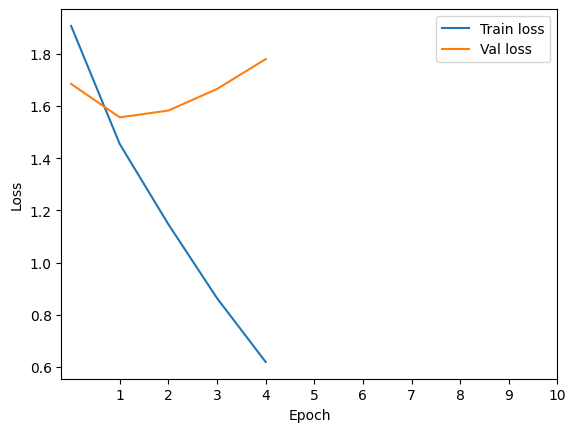

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Test accuracy is 0.38016
Test precision is 0.2708585973682077
Test recall is 0.2655767769521522
Test f1 is 0.21436204876082504


In [119]:
model_base = Sequential()
model_base.add(Embedding(max_words, 25))
model_base.add(Flatten())
model_base.add(Dense(num_classes, activation='softmax'))

test_model(model_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2240 - loss: 1.9976 - val_accuracy: 0.3626 - val_loss: 1.6773
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4671 - loss: 1.4892 - val_accuracy: 0.3896 - val_loss: 1.5586
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6490 - loss: 1.1208 - val_accuracy: 0.3783 - val_loss: 1.6009
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7976 - loss: 0.7905 - val_accuracy: 0.3657 - val_loss: 1.7041
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9025 - loss: 0.5222 - val_accuracy: 0.3551 - val_loss: 1.8385
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9621 - loss: 0.3299 - val_accuracy: 0.3532 - val_loss: 1.9875
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9876 - loss: 0.2025 - val_accuracy: 0.3516 - val_loss: 2.1412


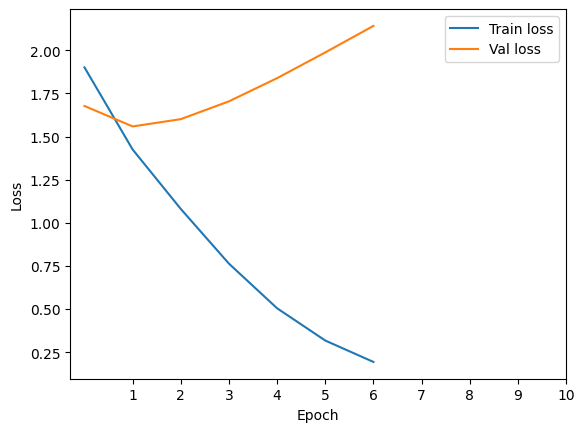

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy is 0.42186666666666667
Test precision is 0.3539122711895373
Test recall is 0.3330185632829781
Test f1 is 0.3199384452700236


In [22]:
model_base2 = Sequential()
model_base2.add(Embedding(max_words, 30))
model_base2.add(Flatten())
model_base2.add(Dense(num_classes, activation='softmax'))

test_model(model_base2, X_train, y_train, X_test, y_test, X_val, y_val)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2366 - loss: 1.9857 - val_accuracy: 0.3868 - val_loss: 1.6355
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5039 - loss: 1.4218 - val_accuracy: 0.4006 - val_loss: 1.5557
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7223 - loss: 0.9825 - val_accuracy: 0.3836 - val_loss: 1.6350
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8849 - loss: 0.5838 - val_accuracy: 0.3670 - val_loss: 1.7751
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9679 - loss: 0.3099 - val_accuracy: 0.3595 - val_loss: 1.9368


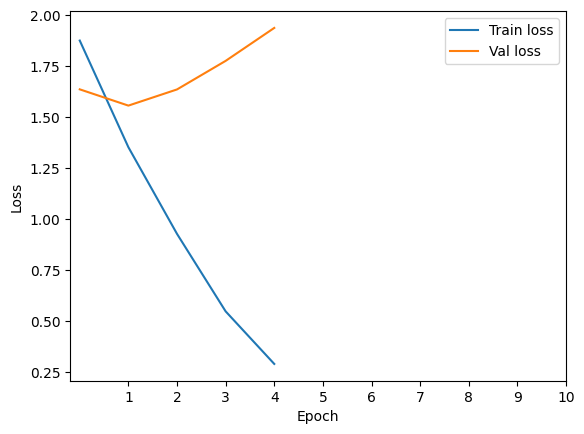

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.40746666666666664
Test precision is 0.40746666666666664
Test recall is 0.40746666666666664
Test f1 is 0.40746666666666664


In [88]:
model_base3 = Sequential()
model_base3.add(Embedding(max_words, 45))
model_base3.add(Flatten())
model_base3.add(Dense(num_classes, activation='softmax'))

test_model(model_base3, X_train, y_train, X_test, y_test, X_val, y_val)

Модель становится лучше для 2 модели, и хуже для 3

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.2429 - loss: 1.9859 - val_accuracy: 0.3338 - val_loss: 1.7869
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.3738 - loss: 1.6823 - val_accuracy: 0.3519 - val_loss: 1.7015
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.4819 - loss: 1.4377 - val_accuracy: 0.3551 - val_loss: 1.7478
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.5644 - loss: 1.2401 - val_accuracy: 0.3535 - val_loss: 1.8107
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.6279 - loss: 1.0908 - val_accuracy: 0.3309 - val_loss: 1.9473


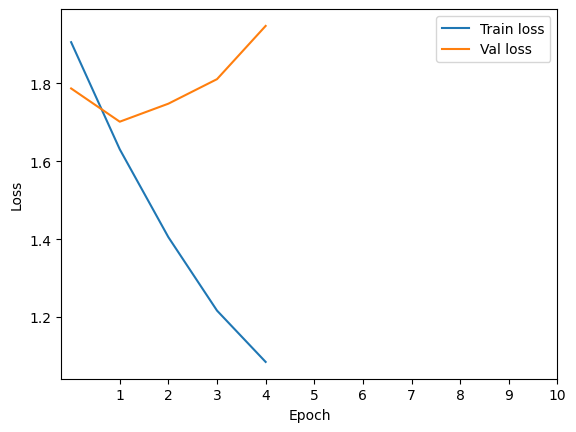

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test accuracy is 0.3453333333333333
Test precision is 0.3453333333333333
Test recall is 0.3453333333333333
Test f1 is 0.3453333333333333


In [89]:
model_rnn_base = Sequential()
model_rnn_base.add(Embedding(max_words, 30))
model_rnn_base.add(SimpleRNN(12))
model_rnn_base.add(Dense(num_classes, activation='softmax'))

test_model(model_rnn_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает результат хуже

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.1799 - loss: 2.0537 - val_accuracy: 0.2258 - val_loss: 2.0055
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.2844 - loss: 1.9270 - val_accuracy: 0.3190 - val_loss: 1.8089
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.3775 - loss: 1.6773 - val_accuracy: 0.3428 - val_loss: 1.7506
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.4459 - loss: 1.4995 - val_accuracy: 0.3428 - val_loss: 1.7515
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.4998 - loss: 1.3592 - val_accuracy: 0.3388 - val_loss: 1.8093


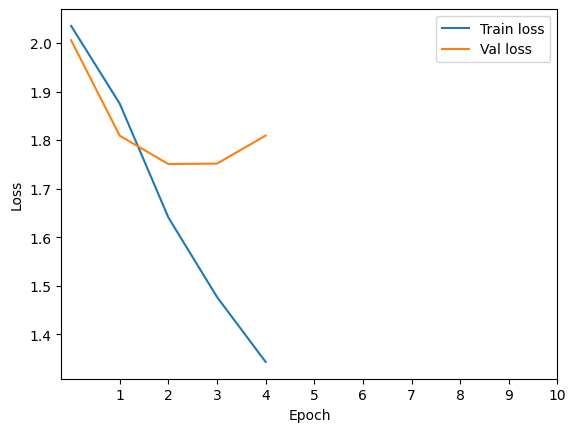

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test accuracy is 0.24026666666666666
Test precision is 0.24026666666666666
Test recall is 0.24026666666666666
Test f1 is 0.24026666666666666


In [90]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(max_words, 15))
model_rnn2.add(SimpleRNN(12))
model_rnn2.add(Dropout(0.25))
model_rnn2.add(Dense(num_classes, activation='softmax'))

test_model(model_rnn2, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой делает только хуже.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.1758 - loss: 2.0604 - val_accuracy: 0.2277 - val_loss: 2.0108
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.2589 - loss: 1.9760 - val_accuracy: 0.2782 - val_loss: 1.9312
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.3240 - loss: 1.8267 - val_accuracy: 0.3435 - val_loss: 1.7505
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.3943 - loss: 1.6406 - val_accuracy: 0.3494 - val_loss: 1.7358
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.4300 - loss: 1.5447 - val_accuracy: 0.3422 - val_loss: 1.7711


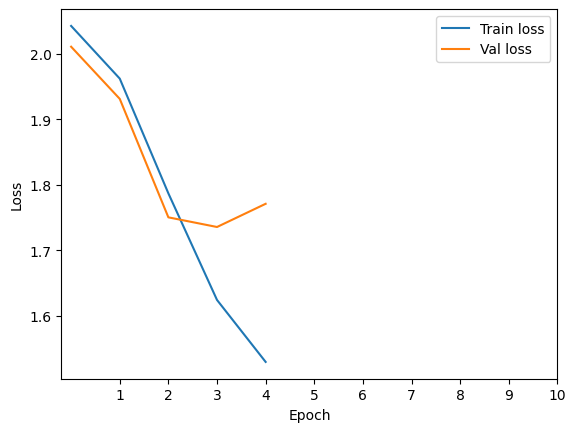

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test accuracy is 0.23866666666666667
Test precision is 0.23866666666666667
Test recall is 0.23866666666666667
Test f1 is 0.23866666666666667


In [95]:
model_rnn3 = Sequential()
model_rnn3.add(Embedding(max_words, 15))
model_rnn3.add(SimpleRNN(12))
model_rnn3.add(Dropout(0.5))
model_rnn3.add(Dense(num_classes, activation='softmax'))

test_model(model_rnn3, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - accuracy: 0.2037 - loss: 2.0442 - val_accuracy: 0.2594 - val_loss: 1.9242
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.3141 - loss: 1.8530 - val_accuracy: 0.3639 - val_loss: 1.6760
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.3905 - loss: 1.6272 - val_accuracy: 0.3811 - val_loss: 1.6187
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - accuracy: 0.4243 - loss: 1.5224 - val_accuracy: 0.3748 - val_loss: 1.6212
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.4518 - loss: 1.4507 - val_accuracy: 0.3843 - val_loss: 1.6160


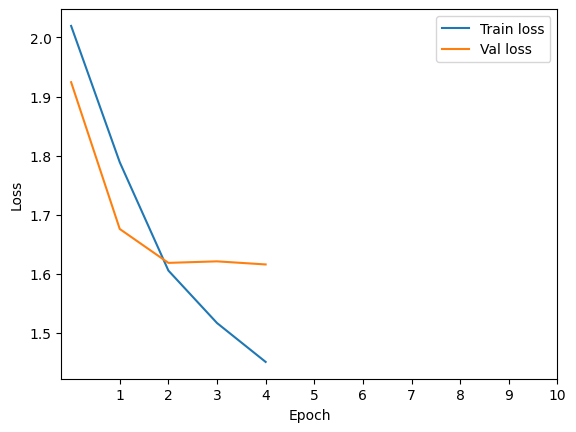

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Test accuracy is 0.2749333333333333
Test precision is 0.2749333333333333
Test recall is 0.2749333333333333
Test f1 is 0.2749333333333333


In [91]:
model_gru_base = Sequential()
model_gru_base.add(Embedding(max_words, 15))
model_gru_base.add(GRU(12))
model_gru_base.add(Dropout(0.5))
model_gru_base.add(Dense(num_classes, activation='softmax'))

test_model(model_gru_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает метрики хуже, чем базовая модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.2411 - loss: 1.9858 - val_accuracy: 0.3457 - val_loss: 1.7199
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.3804 - loss: 1.6318 - val_accuracy: 0.3692 - val_loss: 1.6348
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4275 - loss: 1.4918 - val_accuracy: 0.3745 - val_loss: 1.6335
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.4568 - loss: 1.3998 - val_accuracy: 0.3805 - val_loss: 1.6321
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3318 - val_accuracy: 0.3811 - val_loss: 1.6537


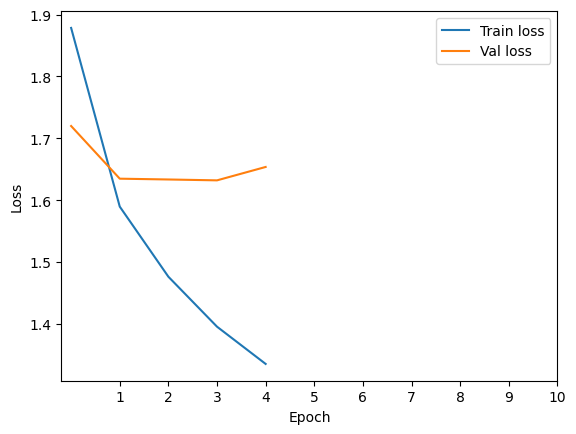

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Test accuracy is 0.36373333333333335
Test precision is 0.36373333333333335
Test recall is 0.36373333333333335
Test f1 is 0.36373333333333335


In [92]:
model_lstm_base = Sequential()
model_lstm_base.add(Embedding(max_words, 15))
model_lstm_base.add(LSTM(12))
model_lstm_base.add(Dense(num_classes, activation='softmax'))

test_model(model_lstm_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель также хуже, чем базовая, еще и обучается дольше

Ситуация аналогична GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.1985 - loss: 2.0252 - val_accuracy: 0.2607 - val_loss: 1.9300
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.2986 - loss: 1.8843 - val_accuracy: 0.2867 - val_loss: 1.8818
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.3577 - loss: 1.7773 - val_accuracy: 0.3187 - val_loss: 1.8179
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.4151 - loss: 1.6512 - val_accuracy: 0.3585 - val_loss: 1.7360
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.4605 - loss: 1.5015 - val_accuracy: 0.3855 - val_loss: 1.6965


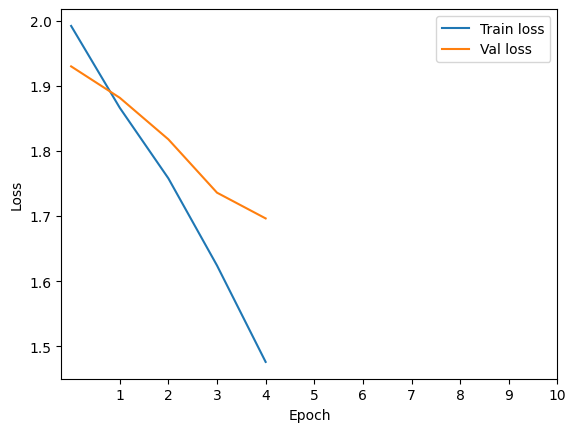

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Test accuracy is 0.2584
Test precision is 0.2584
Test recall is 0.2584
Test f1 is 0.2584


In [93]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(max_words, 15))
model_lstm2.add(LSTM(6))
model_lstm2.add(Dense(num_classes, activation='softmax'))

test_model(model_lstm2, X_train, y_train, X_test, y_test, X_val, y_val)

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 57s 87ms/step - accuracy: 0.2334 - loss: 2.0029 - val_accuracy: 0.3284 - val_loss: 1.7795
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.3470 - loss: 1.7632 - val_accuracy: 0.3338 - val_loss: 1.7085
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.3653 - loss: 1.6550 - val_accuracy: 0.3394 - val_loss: 1.6983
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.3856 - loss: 1.5726 - val_accuracy: 0.3422 - val_loss: 1.7154
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.4135 - loss: 1.5228 - val_accuracy: 0.3560 - val_loss: 1.6994


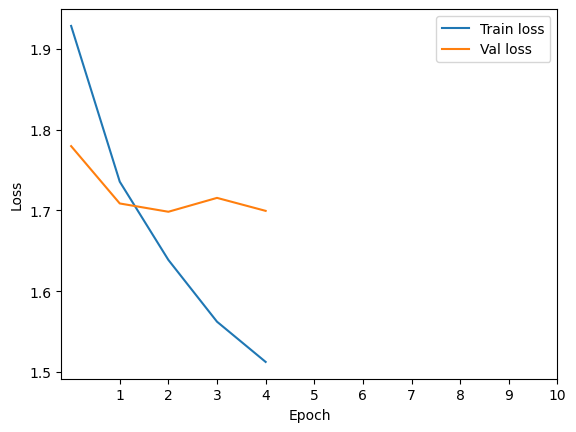

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Test accuracy is 0.34346666666666664
Test precision is 0.34346666666666664
Test recall is 0.34346666666666664
Test f1 is 0.34346666666666664


In [94]:
model_lstm3 = Sequential()
model_lstm3.add(Embedding(max_words, 30))
model_lstm3.add(LSTM(6, return_sequences=True))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(LSTM(6))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(num_classes, activation='softmax'))

test_model(model_lstm3, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1975 - loss: 2.0478 - val_accuracy: 0.2406 - val_loss: 1.9485
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2678 - loss: 1.9373 - val_accuracy: 0.3203 - val_loss: 1.8290
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3207 - loss: 1.8147 - val_accuracy: 0.3278 - val_loss: 1.7486
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3574 - loss: 1.7015 - val_accuracy: 0.3322 - val_loss: 1.7228
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3814 - loss: 1.5982 - val_accuracy: 0.3388 - val_loss: 1.7167


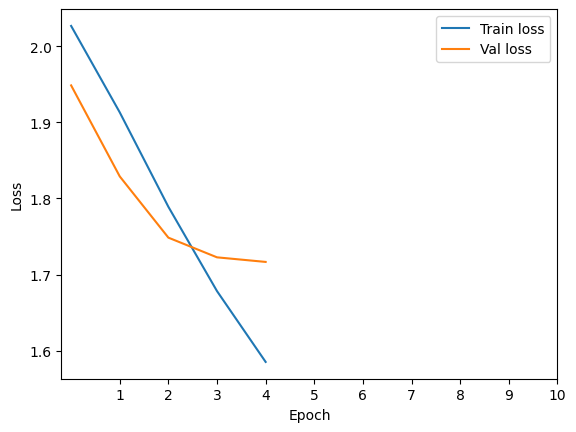

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.24
Test precision is 0.24
Test recall is 0.24
Test f1 is 0.24


In [96]:
model_fully = Sequential()
model_fully.add(Embedding(max_words, 30))
model_fully.add(Flatten())
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(num_classes, activation='softmax'))

test_model(model_fully, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проверим модель на тесте

In [121]:
df_test = pd.read_csv('../data/test.csv')

In [122]:
texts_test = df_test['text'].astype(str)
labels_test = df_test['rating']

In [123]:
sequences_test = tokenizer.texts_to_sequences(texts_test) #Уже обученный на трейн текстах токенизатор

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = encoder.transform(np.array(labels_test))

In [124]:
y_pred = model_base2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [125]:
calculate_metrics(y_pred, y_test)

Test accuracy is 0.41492
Test precision is 0.34135791215975164
Test recall is 0.32926261130900125
Test f1 is 0.3121202903040115


Результаты не самые лучшие, но лучшего добиться не удалось.<br><br/>
Возможно для решения этой задачи требуется больше данных и более сложные модели.

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.


Сохраним эту модель

In [24]:
model_base2.save('../model_params/custom_nn_rating.h5')